In [24]:
from pathlib import Path

import numpy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm

In [2]:
#strainGE_dir= Path("../Respiratory/StrainGE/")
strainGE_dir= Path("../Respiratory/MAGs_StrainGE/")

In [3]:
straingst_df = pd.read_table(strainGE_dir/"StrainGST.tsv", index_col=[0,1])
straingst_df.head()

i  gkmers  ikmers  skmers    cov    kcov    gcov   acct  \
Sample  strain                                                            
C163-2m MAG70   0   19725   19718   17279  0.800   7.340   5.820  0.977   
C225-4m MAG70   0   19725   19724    9492  0.398   1.502   0.590  0.851   
        MAG65   1   18775   18771    1647  0.077   1.209   0.093  0.847   
C136-2m MAG65   0   18775   18775   16380  0.847  36.050  30.444  0.998   
C168-4m MAG65   0   18775   18744   28097  0.858   6.794   5.819  0.860   

                 even   spec  rapct  old_rapct  wscore  score  
Sample  strain                                                 
C163-2m MAG70   0.802  0.999  0.268      0.261   0.502  0.503  
C225-4m MAG70   0.893  1.009  0.029      0.026   0.268  0.270  
        MAG65   0.868  1.000  0.002      0.004   0.049  0.049  
C136-2m MAG65   0.847  1.000  3.151      3.145   0.605  0.606  
C168-4m MAG65   0.861  1.000  0.380      0.639   0.547  0.547

In [4]:
STRAINGR_DIR = strainGE_dir/"Intermediate_files/StrainGR/summary/"

df_list = []
sample_names = []
for f in STRAINGR_DIR.glob("*.tsv"):
    df = pd.read_csv(f, sep='\t', index_col=0)
    df = df.drop(index='TOTAL')  # Remove TOTAL statistics

    df_list.append(df)
    sample_names.append(f.stem)

straingr_df = pd.concat(df_list, keys=sample_names, names=["sample"])

straingr_df['straingst_present'] = straingr_df.index.isin(straingst_df.index)

straingr_df.to_csv(strainGE_dir /"StrainGR_summary.tsv", sep='\t')

In [5]:
straingr_df.head()

name  length  coverage  uReads  abundance  median  callable  \
sample  ref                                                                     
C047-2m MAG66  MAG66_1  416694     2.262    7515      9.688       2    255845   
        MAG66  MAG66_2  301708     2.931    7003      8.999       3    215638   
        MAG66  MAG66_3  272843     2.901    6292      8.085       3    207350   
        MAG66  MAG66_4  239337     3.500    6665      8.609       3    196444   
        MAG66  MAG66_5  101037     3.098    2502      3.215       3     79782   

               callablePct  confirmed  confirmedPct  ...  snpPct  multi  \
sample  ref                                          ...                  
C047-2m MAG66       61.399     249922        97.685  ...   2.315     72   
        MAG66       71.472     211408        98.038  ...   1.960     25   
        MAG66       75.996     203457        98.122  ...   1.878     42   
        MAG66       82.078     192288        97.884  ...   2.115     28   
        MAG66       78.963      78463        98.347  ...   1.653      7   

               multiPct  lowmq  lowmqPct  high  highPct  gapCount  gapLength  \
sample  ref                                                                    
C047-2m MAG66     0.028    798     0.192    22    0.005         3      64786   
        MAG66     0.012    360     0.119     0    0.000         3      24258   
        MAG66     0.020     96     0.035     0    0.000         0          0   
        MAG66     0.014    929     0.388     0    0.000         1       6068   
        MAG66     0.009      0     0.000     0    0.000         0          0   

               straingst_present  
sample  ref                       
C047-2m MAG66               True  
        MAG66               True  
        MAG66               True  
        MAG66               True  
        MAG66               True  

[5 rows x 21 columns]

In [6]:
# aggregate

straingr_df.eval("Density= coverage*length",inplace=True)
straingr_agg = straingr_df.groupby(level=[0,1]).sum()



#drop percentage
straingr_agg= straingr_agg.loc[:,~ straingr_agg.columns.str.contains("Pct")]

straingr_agg.drop(["median","abundance","coverage"],axis=1,inplace=True)

# length weighted coverage 
straingr_agg.eval("coverage = Density/length",inplace=True)

straingr_df = straingr_agg


In [7]:

straingr_df['is_plasmid'] = straingr_df['length'] < 4e4
straingr_df['enough_cov'] = straingr_df['coverage'] > 0.5

straingr_df['straingst_present'] = straingr_df.index.isin(straingst_df.index)

In [8]:


# Filter and re-index
straingr_df = straingr_df[straingr_df['straingst_present'] & ~straingr_df['is_plasmid'] & straingr_df['enough_cov']].reset_index().set_index(['sample', 'ref'])
straingr_df

length  uReads  callable  confirmed   snps  multi  lowmq  \
sample  ref                                                                
C047-2m MAG66  1841312   41560   1318036    1290844  27183    218   4321   
        MAG70  1996732   19306    772262     766677   5582    662  46249   
C238-2m MAG70  1996732   11960    476161     473183   2977    135  22640   
        MAG65  1883560   76249   1498177    1445469  52651    510  12920   
C246-2m MAG70  1996732    7554    274701     272759   1942     61  16112   
...                ...     ...       ...        ...    ...    ...    ...   
C265-4m MAG66  1841312   27008    996950     961717  35219    256   4659   
        MAG70  1996732   21988    874796     869132   5663    285  36579   
        MAG65  1883560   22583    915764     910925   4839     96   3920   
C272-4m MAG66  1841312   70153   1567760    1533813  33909    591   7664   
        MAG70  1996732   41292   1365339    1356863   8470    706  63888   

               high  gapCount  gapLength  straingst_present      Density  \
sample  ref                                                                
C047-2m MAG66   191        10     119208               True  5221598.851   
        MAG70   186         4      37997               True  2716889.215   
C238-2m MAG70     0         2      27721               True  1625757.849   
        MAG65     6         5      92623               True  9368296.162   
C246-2m MAG70     0         1      13555               True  1033267.580   
...             ...       ...        ...                ...          ...   
C265-4m MAG66   203         8     113046               True  3446723.933   
        MAG70   941         4      58124               True  3095607.631   
        MAG65     0         2      49958               True  2953523.436   
C272-4m MAG66   208        10      71181               True  9096351.877   
        MAG70   255         3      32374               True  5792836.053   

               coverage  is_plasmid  enough_cov  
sample  ref                                      
C047-2m MAG66  2.835803       False        True  
        MAG70  1.360668       False        True  
C238-2m MAG70  0.814209       False        True  
        MAG65  4.973718       False        True  
C246-2m MAG70  0.517479       False        True  
...                 ...         ...         ...  
C265-4m MAG66  1.871885       False        True  
        MAG70  1.550337       False        True  
        MAG65  1.568054       False        True  
C272-4m MAG66  4.940147       False        True  
        MAG70  2.901159       False        True  

[594 rows x 15 columns]

In [13]:
straingr_df.groupby(level=1).size()

ref
MAG64     67
MAG65    135
MAG66    166
MAG70    226
dtype: int64

In [30]:
straingr_df.groupby(level=[0,1]).size().unstack().to_csv( strainGE_dir/"Strain_called.tsv",sep='\t')

# Comparison data

not yet finished

In [32]:
Comparison_dir= strainGE_dir/"Intermediate_files/StrainGR/comparisons/summary/"

# increases with time
comparison_list = list(Comparison_dir.glob("*.tsv"))
print(len(comparison_list) )

df_list =[]
for file in tqdm(comparison_list):
    try: 
        df= pd.read_table(file, index_col=[0,1,2])
        df_list.append(df)
    except pd.errors.EmptyDataError:
        pass
    
compare_df = pd.concat(df_list)
compare_df.to_csv(strainGE_dir/"Comparisons.tsv",sep="\t")

6300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6300/6300 [02:50<00:00, 37.02it/s]


# Comparison

In [16]:

compare_df = pd.read_csv(strainGE_dir /"Comparisons.tsv", sep='\t', index_col=[0, 1, 2])

In [17]:
#aggregate

compare_agg = compare_df.groupby(level=[0,1,2]).sum()
compare_agg.eval("singleAgreePct = singleAgree/single*100", inplace=True)
compare_agg.eval("commonPct = common/length*100", inplace=True)


compare_df= compare_agg

In [33]:
compare_agg.columns

Index(['length', 'common', 'commonPct', 'single', 'singlePct', 'singleAgree',
       'singleAgreePct', 'multi', 'multiPct', 'sharedAlleles',
       'sharedAllelesPct', 'variants', 'variantPct', 'commonVariant',
       'commonVariantPct', 'variantExact', 'variantExactPct', 'AnotB',
       'AnotBpct', 'BnotA', 'BnotApct', 'Agaps', 'AgapPct', 'Bgaps', 'BgapPct',
       'gapJaccardSim', 'both_present'],
      dtype='object')

In [18]:
# comparisoncolumns
unique_sample_genome = straingr_df.index.unique()

def both_straingst_present(ix):
    sample1, sample2, ref = ix

    return (sample1, ref) in unique_sample_genome and (sample2, ref) in unique_sample_genome

compare_df['both_present'] = compare_df.index.map(both_straingst_present)
compare_df = compare_df[compare_df['both_present']].copy()


# add species and genus

compare_df["Species"] = compare_df.index.get_level_values(2).map(lambda s: " ".join(s.split("_",2)[:2]))
compare_df["Genus"] = compare_df.index.get_level_values(2).str.split("_",1,expand=True).to_frame()[0].map({"Stre":"Streptococcus","Stap":"Staphylococcus"}).values




all_compare_df= compare_df.copy()


In [19]:
compare_df.head()

length  common  commonPct  single  singlePct  \
sample1 sample2 ref                                                    
C001-2m C031-4m MAG65  1883560  868347  46.101372  866855   998.4011   
                MAG66  1841312  259936  14.116891  259890  2299.3717   
                MAG70  1996732  278945  13.970077  278641  4195.3826   
C002-4m C055-4m MAG66  1841312  880084  47.796571  879899  2299.6528   
C006-4m C201-4m MAG66  1841312   52944   2.875341   52939  2198.9850   

                       singleAgree  singleAgreePct  multi  multiPct  \
sample1 sample2 ref                                                   
C001-2m C031-4m MAG65       837944       96.664840   1492    1.5989   
                MAG66       255002       98.119204     46    0.6283   
                MAG70       276342       99.174924    304    4.6174   
C002-4m C055-4m MAG66       844887       96.020907    185    0.3472   
C006-4m C201-4m MAG66        50217       94.858233      5    1.0150   

                       sharedAlleles  ...  BnotA   BnotApct   Agaps   AgapPct  \
sample1 sample2 ref                   ...                                       
C001-2m C031-4m MAG65         839388  ...   2952    96.9835  101978  192.6934   
                MAG66         255047  ...   2212   731.1574  106430  174.9995   
                MAG70         276643  ...   1543  2053.7500   71970  100.0000   
C002-4m C055-4m MAG66         845063  ...   9826   594.3759  118227  474.0120   
C006-4m C201-4m MAG66          50222  ...    611   451.2171   58199  200.0000   

                        Bgaps   BgapPct  gapJaccardSim  both_present  Species  \
sample1 sample2 ref                                                             
C001-2m C031-4m MAG65   74200  200.0000         9.8783          True    MAG65   
                MAG66   38921  200.0000        23.9840          True    MAG66   
                MAG70   13940  100.0000        41.8355          True    MAG70   
C002-4m C055-4m MAG66  104632  463.7137        23.6220          True    MAG66   
C006-4m C201-4m MAG66   60144  171.2085        23.9676          True    MAG66   

                       Genus  
sample1 sample2 ref           
C001-2m C031-4m MAG65    NaN  
                MAG66    NaN  
                MAG70    NaN  
C002-4m C055-4m MAG66    NaN  
C006-4m C201-4m MAG66    NaN  

[5 rows x 29 columns]

In [20]:
# filter
compare_df= all_compare_df.query("commonPct>20")

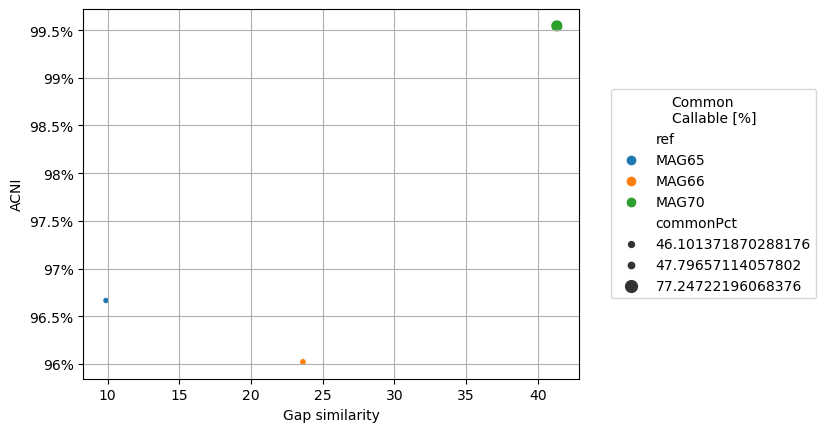

In [21]:
#plot

import seaborn as sns

sns.scatterplot(x="gapJaccardSim", y="singleAgreePct", size="commonPct", data=compare_df,hue="ref")#.query("Genus=='Streptococcus'"), hue="Species")

#plt.xlim(0.970, 1)
plt.xlabel("Gap similarity")

#plt.ylim(99.9, 100)
plt.ylabel("ACNI")
plt.gca().yaxis.set_major_formatter("{x:g}%")

plt.grid('on')
plt.legend(title="Common\nCallable [%]", loc="center left", bbox_to_anchor=(1.05, 0.5))

In [113]:
#plot

import seaborn as sns

sns.distplot(x="ref", y="singleAgreePct", data=compare_df.reset_index())#.query("Genus=='Streptococcus'"), hue="Species")

#plt.xlim(0.970, 1)


#plt.ylim(99.9, 100)
plt.ylabel("ACNI")


plt.grid('on')


TypeError: distplot() got an unexpected keyword argument 'y'

StrainGR compares positions within the “callable genome” or the set of positions with any reference or alternative allele supported by at least two good reads and > 10% of the alignment pileup (Fig. 1c). To perform a comparison, only “common callable” positions are considered, which represent the subset of the callable genome for a given reference that is shared by two samples. Strain relationships can be assessed using two key metrics: (i) the Average Callable Nucleotide Identity (ACNI), or the percentage of common callable positions where both samples have a single identical base call, and (ii) a “gap similarity” metric, as patterns of large deletions are often conserved between closely related strains, which can provide an orthogonal metric of strain similarity [23]. The ACNI and gap similarity values that define two samples as containing the same “strain” depend on the research question [7]. For the purposes of this manuscript, we consider two samples to contain the same strain if ACNI is ≥ 99.95%, which

In [22]:
compare_df.query("singleAgreePct>99.95") 

,,,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,multi,multiPct,sharedAlleles,...,BnotA,BnotApct,Agaps,AgapPct,Bgaps,BgapPct,gapJaccardSim,both_present,Species,Genus
sample1,sample2,ref,,,,,,,,,,,,,,,,,,,,,
